# A|B Testing: Two Sample Proportion 

<h1 style="color: white; padding: 10px; border-radius: 5px; background: linear-gradient(to right,  #BBC4F9, #BBC4F9);">Abstract</h1>

<div style="border: 4px solid; 
            padding: 20px; 
            border-radius: 10px;
            border-image: linear-gradient(to right, #BBC4F9, #BBC4F9) 1;">
    <p><strong>Context:</strong> <br></br>
Assisted a company in evaluating the effectiveness of a new Call-to-Action button on their landing page, designed to increase visitor engagement. The primary change between the two versions lies in the Call-to Action (CTA) button text:    
    <li>
        New Version CTA: <strong>"Secure Free Trial"</strong>
    </li>
    <li>
        Existing Version CTA: <strong>"Enroll Now"</strong>
    </li>
    <br>
    </br>
Collaborated with the company's subject matter expert, who defined a minimum detectable effect (MDE) of a 10% increase in engagement as the threshold for implementing the new button. The company has provided performance data for both versions and aims to determine which version drives higher visitor engagement. For the primary metric. The company will measure engagement based on Click-Through Rate (CTR), representing the proportion of visitors who click the Call-to Action (CTA) button. The analysis will inform a data-driven decision on whether to replace the existing CTA with the new version to optimize user engagement and improve visitor engagement.
    </p>
    <br>
    <br/>
    <p>
    <strong>Objectives:</strong>
    </p>
    <ul style="list-style-type: disc; padding-left: 20px; margin-top: 10px;">
        <li style="margin-bottom: 10px;">
 Evaluate if the new Call-to Action (CTA) button significantly improves Click-Through Rate (CTR) over the existing one, and determine if the difference is statistically significant or due to random variation.
        </li>
        <li style="margin-bottom: 10px;">
Assess the practical significance of implementing the new Call-to Action (CTA) button.
        </li>
    </ul>
    <br/>
</div>


<br></br>

<br></br>

<h1 style="color: white; padding: 10px; border-radius: 5px; background: linear-gradient(to right, #BBC4F9, #BBC4F9);">Data Dictionary</h1>

|Column|Description|Datatype|
|-|-|-|
|`user_id`|A 6 character string ID|`obj`|
|`group`|What group the observation belongs to|`obj`|
|`click`|Did the observation click? 1:(Yes) / 0:(No)|`bool`|
|`date`|The date the visitor visited the website. YYYY-MM-DD|`datetime`|

<br></br>

<br></br>

<h1 style="color: white; padding: 10px; border-radius: 5px; background: linear-gradient(to right, #BBC4F9, #BBC4F9);">Load Data & Packages</h1>

**Import Packages**

In [1]:
# Operational Packages
import pandas as pd
import numpy as np

# Visualization Packages
import matplotlib.pyplot as plt
import seaborn as sns


# Statistical Package
from scipy import stats
from statsmodels.stats.power import NormalIndPower

# Cohen' h effect size (unqual sample(S) variance)
from statsmodels.stats.proportion import proportion_effectsize

# Z-test for two tailed proportions
from statsmodels.stats.proportion import proportions_ztest


<br></br>


**Load Dataset**

In [2]:
# Load in the dataset
test_df = pd.read_csv('ab_testing_data.csv')
test_df.head(5)

,user_id,group,click,date
0,8eb2c5,exp,1,2024-02-21
1,9bbefa,exp,0,2024-02-10
2,47b542,exp,1,2024-02-01
3,607951,exp,1,2024-02-11
4,7c6094,exp,1,2024-02-07


<br></br>

In [3]:
# check the basic descriptive statistics of numeric columns
test_df.describe()

,click
count,20000.000000
mean,0.401400
std,0.490194
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


<br></br>

In [4]:
# Check datatypes and rows of the dataset
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   user_id  20000 non-null  object
 1   group    20000 non-null  object
 2   click    20000 non-null  int64 
 3   date     20000 non-null  object
dtypes: int64(1), object(3)
memory usage: 625.1+ KB


<br></br>

<br></br>

**Data Visualization**

In [5]:
# Custom Palette 
palette = {0: 'grey',   # 0 for No-Click
           1: 'lightblue'}   # 1 for Click 

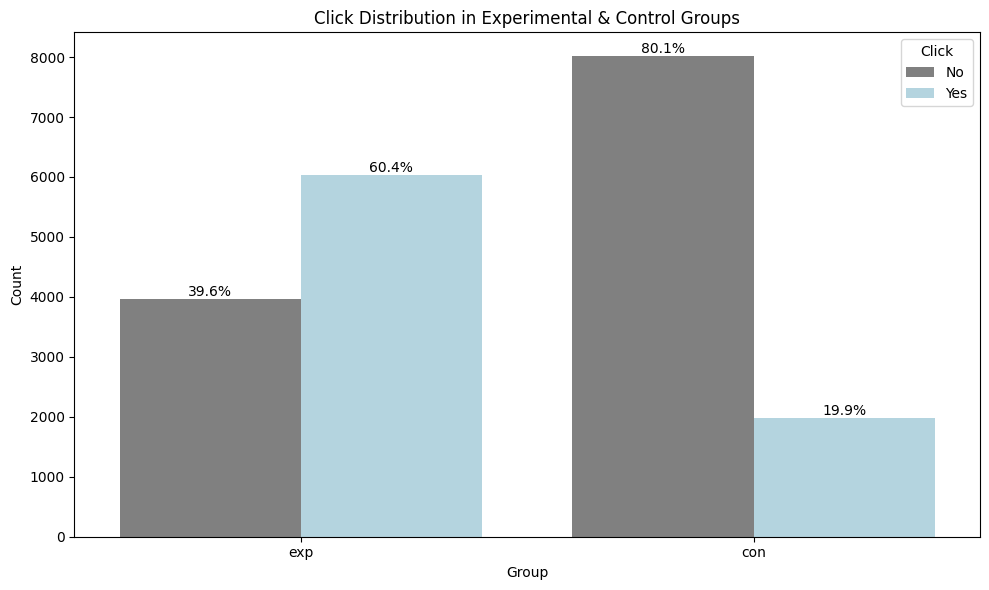

In [6]:
# Plot a Countplot in seaborn 
plt.figure(figsize=(10,6))
ax = sns.countplot(test_df, x='group', hue='click', palette=palette);
plt.title('Click Distribution in Experimental & Control Groups')
plt.xlabel('Group')
plt.ylabel('Count')
plt.legend(title='Click', labels=['No', 'Yes'])


# Calcualte the percentage for annotate the bars
group_counts = test_df.groupby(['group']).size()
group_click_count = test_df.groupby(['group','click']).size().reset_index(name='count')


# Annotate the graph with percnetage
for p in ax.patches:
    height = p.get_height()

    # Skip bars with zero height
    if height == 0:  
        continue  

    # Determine the group based on bar position
    group = 'exp' if p.get_x() < 1 else 'con'  

    # Determine click type using bar color
    click = 1 if p.get_facecolor() == palette[1] else 0  

    # Get total count for percentage calculation
    total = group_counts.loc[group]
    percentage = height / total * 100
    
    # Annotate the percentage on the bars
    ax.text(p.get_x() + p.get_width() / 2., height + 50, f'{percentage:.1f}%', ha='center', color='black', fontsize=10)


plt.tight_layout()
plt.show()

The **experimental group achieved a significantly higher click-through rate (CTR) of 60.4%**, compared to **19.9% in the control group** a difference of approximately 40 percentage points. This substantial uplift suggests a strong impact of the new CTA button. However, to ensure statistical reliability, we need to  validate the significance of this difference through hypothesis testing and analyze confidence intervals.

<br></br>

<br></br>

<h1 style="color: white; padding: 10px; border-radius: 5px; background: linear-gradient(to right, #BBC4F9, #BBC4F9);">Exploratory Data Analysis</h1>

**Compute the `sample size` per Group**

In [7]:
sample_size_con = test_df['group'].value_counts().loc['con']
sample_size_exp = test_df['group'].value_counts().loc['exp']


print(f'(con) Sample size: {sample_size_con}')
print(f'(exp) Sample size: {sample_size_exp}')

(con) Sample size: 10000
(exp) Sample size: 10000


<br></br>

<br></br>

**Calculating `number of clicks` per Group**

In [8]:
# Calculate the number of total clicks for both groups
num_clicks_con = test_df.groupby(['group'])['click'].sum().loc['con'] # Since the click is either a 1 or 0 so the sum == sum of 1(s)
num_clicks_exp = test_df.groupby(['group'])['click'].sum().loc['exp']


# Number of Clicks in each group
print(f'(con) Number of clicks: {num_clicks_con}')
print(f'(exp) Number of clicks: {num_clicks_exp}')

(con) Number of clicks: 1988
(exp) Number of clicks: 6040


<br></br>

<br></br>

**Compute the `Sample Proportion` per Group**

<br></br>

$$
\huge \widehat{P}_{\ group} = {\frac{X_{\ group}}{N_{\ group}}}
$$

<br>

**Estimated Sample Proportion Formula:**
* `P-hat`: Sample Proportion of a specific group.
* `X`: Number of Favorable outcomes in the sample. `number of clicks`
* `N`: Number of sampled user who vistied the websit. `sample size`  

In [9]:
# Compute the proportion for both the control & experimental group
sample_proportion_con = num_clicks_con / sample_size_con
sample_proportion_exp = num_clicks_exp / sample_size_exp

print(f'(con) Click Rate Proportion: {sample_proportion_con:.4f}')
print(f'(exp) Click Rate Proportion: {sample_proportion_exp:.4f}')

(con) Click Rate Proportion: 0.1988
(exp) Click Rate Proportion: 0.6040


<br></br>

<br></br>

**Compute the `estimated pooled proportion`**

<br></br>

$$
\huge \widehat{P}_{\ pooled} = {\frac{X_{ \ con} \ + \  X_{ \ exp} }{N_{\ con} + N_{\ exp}}}
$$

<br>

**Estimated Pooled Proportion Formula:**
* `P-hat_(pooled)`:  Pooled Proportion.
* `X_con`: Number of Clicks in the Control Group.
* `X_exp`: Number of Clicks in the Experimental Group.
* `N_con`: Number of sampled user who vistied the website with the existing CTA button.  
* `N_exp`: Number of sampled user who vistied the website with the new CTA button.  

In [10]:
# Pooled Proportion.  A.K.A pooled success probability.
pooled_proportion = (num_clicks_con + num_clicks_exp) / (sample_size_con + sample_size_exp)
print(f'Pooled Proportion: {pooled_proportion}')

Pooled Proportion: 0.4014


<br></br>

<br></br>

**Compute the `pooled variance`**

<br></br>

$$
\huge \widehat{S}^2_{\ pooled} = \widehat{P}_{\ pooled} \ (1 - \widehat{P}_{\ pooled}) * ({\frac{1}{N_{\ con}}} + {\frac{1}{N_{\ exp}}})
$$

<br>

**Pooled Variance Formula:**
* `S-hat-Squared_(pooled)`:  Pooled Variance.
* `P-hat_(pooled)`: Pooled Proportion = `0.4014`.
* `N_con`: Number of sampled user who vistied the website from the Control Group = `10,000`.  
* `N_exp`: Number of sampled user who vistied the website from the Experimental Group = `10,000`.  

In [11]:
# Pooled variance
pooled_variance = pooled_proportion * (1 - pooled_proportion) * (1/sample_size_con + 1/sample_size_exp)
print(f'Pooled Variance: {pooled_variance}')

Pooled Variance: 4.8055608e-05


<br></br>

<br></br>

**Compute the `pooled standard error`**

<br></br>

$$
\huge SE_{ \ pooled} = \sqrt{ \widehat{S}^2_{\ pooled}} = \sqrt{\widehat{P}_{\ pooled} \ (1 - \widehat{P}_{\ pooled}) * ({\frac{1}{N_{\ con}}} + {\frac{1}{N_{\ exp}}})}
$$

<br>

**Pooled Standard Error Formula:**
* `SE_(pooled)`:  pooled Standard Error.
* `S-hat-Squared_(pooled)`:  Pooled Variance.

In [12]:
# Standard error
SE = np.sqrt(pooled_variance)
print(f'Standard Error: {SE}')

Standard Error: 0.006932215230357465


<br></br>

<br></br>

<h1 style="color: white; padding: 10px; border-radius: 5px; background: linear-gradient(to right, #BBC4F9, #BBC4F9);">Hypothesis of A/B Testing</h1>

**A|B Testing Groups** <br>
* **`Control Group`**: A simple random sample of 10,000 users exposed only to the Existing CTA button: **"Enroll Now"**.
* **`Experimental Group`**: A simple random sample of 10,000 users exposed only to the New CTA button: **"Secure Free Trial"**.

<br></br>

**Minimum Detetectable Effect (MDE):** <br>
<br>
At least a 10% increase in Click Through Rate (CTR) with the new version compared to the existing version would be considered practically significant. This threshold represents a meaningful improvement in user engagement that would justify implementing the new CTA button.

<br></br>

**Statistical Hypothesis Testing:**
* `H₀`: There is no statistical siginficant difference in the Click Through Rate between the existing and new version of the CTA button.
* `H₁`: There is a statistical siginficant difference in the Click Through Rate between the existing and new version of the CTA button.


<br></br>

$$
\huge H_{0}: P_{con} = P_{exp}
$$

$$
\huge H_{1}: P_{con}  ≠ P_{exp}
$$

<br></br>

<br></br>

<h1 style="color: white; padding: 10px; border-radius: 5px; background: linear-gradient(to right, #BBC4F9, #BBC4F9);">A/B Test Design | Power Analysis</h1>

**Define the Parameter(s) for Power Analysis**

<br><br>

|Parameter(s)|Used||
|:-:|:-:|-|
|`significance level (α)`|5% (0.05)|The significance level (α) represents the probability of rejecting the null hypothesis when it is actually true, leading to a Type I error (false positive). In other words, it is the probability of detecting a statistically significant effect when none exists. <br></br>A standard choice for hypothesis testing is 5% (α = 0.05).|
|`Power` <br>`(1 - β)`|80% (0.80)|Power refers to the probability of correctly rejecting the null hypothesis, meaning it represents the likelihood of making the correct decision. <br>β is the probability of making a Type II error (failing to reject a false null hypothesis). <br></br>In A/B testing, a commonly used power = 80%.|
|`Minimum Detectable Effect` <br>`(MDE)`|10% (0.10)|The Minimum Detectable Effect (MDE) is the smallest meaningful change that the test should be able to detect. <br></br>It is determined by subject matter experts and depends on business objectives.|
|`Effect Size` <br>`(δ)`|Cohen’s h|A Threshold use to determine whether we should make the business decision or not after proven statistically significant. <br></br>Cohen’s h measures the difference between two proportions on an arcsine-transformed scale, making it useful for comparing proportions when their variances differ. <br></br> What is the differnce in the CTR that we NEED to detect, after we have proven the result is satistically signifcant. IN Order for us to say that we also have a Practical Significant so practically we are also comfortable making that business decision and then launching this new feature and chaning our landing page. that what is delta.|

<br></br>

<br></br>

**Set the Parameter(s): `α`,  `MDE` and `power`**

In [13]:
# (Alpha) Significant level of 5%
significant_level = 0.05


# Minimum Detectable Effect 10% Increase 
min_detectable_effect = 0.10


# (1 - Beta) Power of the Test
power = 0.80 # the probability that we correctly detect the effect When theere is one

<br></br>

<br></br>

**Compute the Cohen's h `effect size (δ)`**

<br></br>

$$
\huge h = 2 arcsin({\sqrt{\widehat{P}_{ \ con}}}) - 2 arcsin({\sqrt{\widehat{P}_{ \ exp}}})
$$

In [14]:
# (Delta) Calculate effect size (Cohen's h)
effect_size = proportion_effectsize(sample_proportion_con, min_detectable_effect)
print(f'Effect Size: {effect_size:.4f}')

Effect Size: 0.2808


<br></br>

<br></br>

**Find the `minimum sample` per group**

In [15]:
# Use NormalIndPower to calculate sample size for two-sided test
power_analysis = NormalIndPower()
min_sample_size = power_analysis.solve_power(effect_size=effect_size, alpha=significant_level, power=power, ratio=1)

print(f"Minimum Sample Size per group: {min_sample_size:.0f}")

Minimum Sample Size per group: 199


<br></br>

<br></br>

<h1 style="color: white; padding: 10px; border-radius: 5px; background: linear-gradient(to right, #BBC4F9, #BBC4F9);">A/B Test Design | Test Duration</h1>

**Try to Avoid when running A/B Test:** <br>

<br></br>

|Effects|Duration||
|:-:|:-:|-|
|`Novelty Effects`|less than 2 weeks|When the test duration is too short, people tend to react quickly to change|
|`Maturation Effecs`|4+ weeks|When the test duration is too long, the higher the likelihood of external effect impacting the reactions of the users and possibly contaminating the test result|

<br></br>

To observe the **true treatment effect**, it is generally advisable to allow users enough time to adjust to new features or changes. Running the test long enough helps users **"cool down"** from their initial reactions, reducing the **Novelty Effect** and providing a more predictive and accurate measurement of long-term user behavior. However, extending the test too long may introduce external influences, so careful monitoring is essential to maintain result validity.

In [16]:
# A/B Test Duration
daily_vistiors_df = test_df.groupby(['date'])[['user_id']].count().reset_index()
avg_daily_visitors = daily_vistiors_df['user_id'].mean()
print(f'Average Daily Visitors: {avg_daily_visitors:.0f}')


# Compute number of day(s) needed for the data collection
days = ((2*min_sample_size) / avg_daily_visitors)
print(f'{days:.2f} Day(s)')

Average Daily Visitors: 909
0.44 Day(s)


Determining the optimal **test duratio**n is a complex process, but a simplified approach based on this experiment's data can help simplify the process. With a **minimum required sample size** of 199 per group and an **average daily collection of 909 samples**, with data being gathered within 44% of a 24-hour period (approximately 10.5 hours), we can estimate the sample accumulation. By calculating 909 × 0.44 ≈ 400, we obtain around 200 samples per group per day, which closely aligns with the **minimum sample size requirement**. However, since data is collected in a relatively short period, it is highly susceptible to the **Novelty Effect**, where users may initially react differently due to the introduced change. Given that this dataset consists of synthetic data, I will conclude the analysis here for **Test Duration**.

<br></br>

<br></br>

<h1 style="color: white; padding: 10px; border-radius: 5px; background: linear-gradient(to right, #BBC4F9, #BBC4F9);">Two Sample Z-test for Proportions</h1>

<div style="border: 4px solid; 
            padding: 20px; 
            border-radius: 10px;
            border-image: linear-gradient(to right, #BBC4F9, #BBC4F9) 1;">
    <p><strong>Two Sample Z-Test:</strong> <br></br>
The reason to use the Two Samples Z-Test (Proportrion) for this senario: first we have 2 sampled groups: <strong>Control</strong> and <strong>Experimental</strong> and we found the <strong>Click-Through Rate (CTR)</strong> for each group. Second we have a large sample size of 10,000 in each group. Since the T-test are useful for a sample size below 30, and T-test does not apply to proportions. therefore, I used the Two-sample Z-test for proportions for this senario. 
    </p>  
</div>

**Z-Statistic Formula:**

<br></br>

$$
\huge Z \ Statistic  = {\frac{\widehat{P}_{ \ con} - \widehat{P}_{ \ exp}}{SE_{\ pooled}}}
$$

<br>

* `SE_(pooled)`:  pooled Standard Error.
* `sample_proportion_con`: Click Through Rate of the Control Group.
* `sample_proportion_exp`: Click Through Rate of the Experimental Group.

In [17]:
# Z-Test Statistics
test_statistic = (sample_proportion_con - sample_proportion_exp) / SE
print(f'Z-Test Statistic for Two-sample: {test_statistic}')


# Z-Score or critical value
Z_score = stats.norm.ppf(1- significant_level/2 )                         # percentage probability function .ppf( ) 
print(f'Z-Score from Standard Normal Distribution: {Z_score:.2f}')

Z-Test Statistic for Two-sample: -58.451733902541505
Z-Score from Standard Normal Distribution: 1.96


<br>

The **Z-Test statistic is negative**, meaning that the **Click Through Rate (CTR)** in the experimental group is larger than our control group. For our case this is a good indication that the new version has higher click rate proportion than the exsting.  

<br></br>

|Significant Level|Confidence Level|Z-Score|
|-|-|-|
|10%|90%|1.645|
|5%|95%|1.96|
|1%|99%|2.58|

<br></br>

<br></br>

**Calculate the `P-value`**

The p-value represents the probability of obtaining a test statistic as extreme as, or more extreme than, the observed value purely due to random chance, assuming the null hypothesis is true. A high p-value suggests that any observed difference in click rates between the experimental and control groups is likely due to random variation rather than a true statistical difference.

In [18]:
# P-value
p_value = 2 * stats.norm.sf(abs(test_statistic)) # times 2 for account for both tail of the distribution
print(f'P-Value: {p_value}')

P-Value: 0.0


<br></br>

<br></br>

**Compute the `Z-test with statsmodels`**

In [19]:
# Proportions per group
count = [num_clicks_con, num_clicks_exp]


# Sample size per group 
nobs = [sample_size_con, sample_size_exp]


# from statsmodels.stats.proportion import proportions_ztest
z_stats, p_value = proportions_ztest(count, nobs)
print('Z-statistic:', z_stats, '\nP-value:',p_value)

Z-statistic: -58.451733902541505 
P-value: 0.0


<br></br>

<br></br>

<h1 style="color: white; padding: 10px; border-radius: 5px; background: linear-gradient(to right, #BBC4F9, #BBC4F9);">Evaluate the Hypothesis Result</h1>

In [20]:
# recall the significant_level
print(f'Significant Level: {significant_level}')

Significant Level: 0.05


In [21]:
def hypothesis_result(p_value, significant_level):
    '''
    Evaluates the hypothesis test result by comparing the p-value with the significance level.
       
        Parameters:
            p_value            (float): The calculated p-value from the test.
            signficant_level   (float): The threshold for statistical significance.

        Returns:
            (string) A statement indicating whether we reject or fail to reject the null hypothesis.
    '''

    
    # When P-value is greater than or euql to the significant level
    if p_value >= significant_level:
        print(f'The P-value of {p_value:.3f} greater than significant level of {significant_level}. We fail to reject the Null Hypothesis. \n' 
              f'Which means the difference in click-through rates is not statistically significant. \n',
              f'This suggests that the observed difference is likely due to random chance.')

    
    # when P-value is less than the significant level
    else:
        print(f'The P-value of {p_value:.3f} is less than the significance level of {significant_level}. We reject the Null Hypothesis. \n' 
              f'Which means the difference in click-through rates is statistically significant. \n' 
              f'This suggests that the observed difference is unlikely due to random chance, meaning the change had a real impact.')

In [22]:
# Call the hypothesis_result Helper function
hypothesis_result(p_value, significant_level)    

The P-value of 0.000 is less than the significance level of 0.05. We reject the Null Hypothesis. 
Which means the difference in click-through rates is statistically significant. 
This suggests that the observed difference is unlikely due to random chance, meaning the change had a real impact.


<br></br>

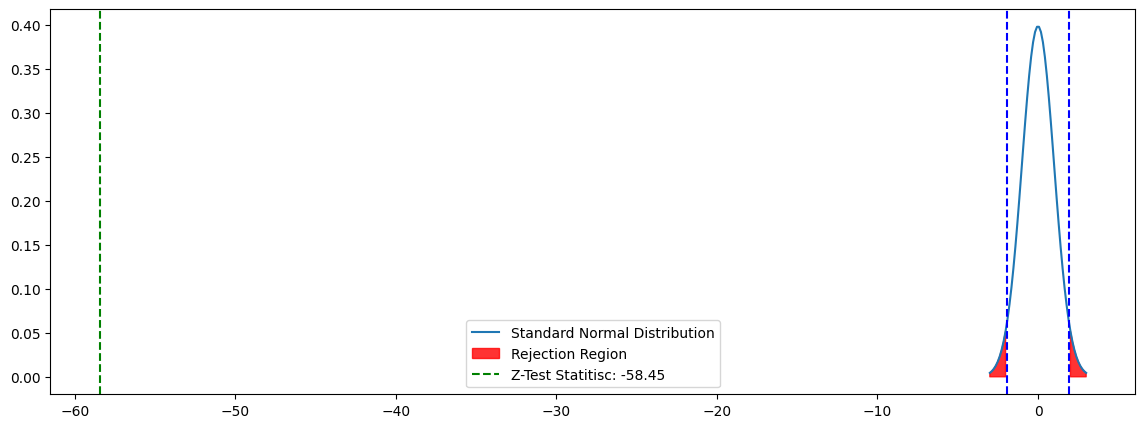

In [23]:
# Parameters on the standard normal distributions

plt.figure(figsize=(14,5))

mu = 0                                                  # Mean of the standard normal distribution
sigma = 1                                               # Standard deviation of the standard normal distribution

x = np.linspace(mu - 3*sigma, mu + 3*sigma)             # Generating the x values for the standard normal distribution
y = stats.norm.pdf(x, mu, sigma)                        # Calculating the corresponding y values
plt.plot(x,y, label='Standard Normal Distribution')


# Highlight the rejection regions (areas beyond the critical Z-scores)
plt.fill_between(x,y, where = (x > Z_score) | (x < -Z_score), color='red', alpha=0.8, label='Rejection Region')


# Plot the critical Z-scores (thresholds for rejection region)
plt.axvline(Z_score, color='blue', linestyle='dashed')
plt.axvline(-Z_score, color='blue', linestyle='dashed')


# Plot the test statistic
plt.axvline(test_statistic, color='green', linestyle='dashed', label=f'Z-Test Statitisc: {test_statistic:.2f}')
plt.legend()
plt.show()

The green dashed line on the far left shows a Z-test statistic of -58.45, which is 58.45 standard deviations away from the standardized mean of zero. This indicates the likelihood of the difference being due to chance is extremely low, nearly zero. And we can reject the Null Hypothesis.

<br></br>

<br></br>

**Compute the `Confidence Interval`**

In [24]:
# recall the standard error 
print(f'(Pooled) Standard Error: {SE}')

(Pooled) Standard Error: 0.006932215230357465


In [25]:
# Define a helper function to calculate Confidence Interval
def confidence_intervals(confidence_level, p1, p2, standard_error):
    '''
    Calculate the lower and upper bound confidence interval.

        Parameters:
          confidence_level (float): The confidence level (e.g., 0.95 for a 95% confidence interval)
          p1               (float): Sample proportion from group 1 (control)
          p2               (float): Sample proportion from group 2 (experimental)
          standard_error   (float): Standard error of the difference between proportions (pooled)
        
        Returns:
          conf_interval    (tuple): A tuple containing the lower and upper bounds of the confidence interval
    '''

    # Calculate the absolute difference between the sample proportions
    proportion_diff = abs(p1-p2)

    
    # Calculate the confidence interval using the normal distribution
    conf_interval = stats.norm.interval(confidence=confidence_level, loc=proportion_diff, scale=standard_error)
    
    return conf_interval

In [26]:
# Call the ` confidence_intervals( ) ` helper function 
CI_95 = confidence_intervals(0.95, sample_proportion_con, sample_proportion_exp, SE)


# Print the confidence interval and bounds
print(f'{CI_95} \n')
print(f'Lower Bound: {CI_95[0]:.3f}', f'\nUpper Bound: {CI_95[1]:.3f}')

(0.39161310781541936, 0.41878689218458065) 

Lower Bound: 0.392 
Upper Bound: 0.419


<br></br>

<br></br>

<h1 style="color: white; padding: 10px; border-radius: 5px; background: linear-gradient(to right, #BBC4F9, #BBC4F9);">Evaluates Practical Significant Result</h1>

<div style="border: 4px solid; 
            padding: 20px; 
            border-radius: 10px;
            border-image: linear-gradient(to right, #BBC4F9, #BBC4F9) 1;">
    <p>
After establishing statistical significance, we now assess practical significance. If the lower bound of the confidence interval meets or exceeds the effect size, and the effect size is greater than the Minimum Detectable Effect (MDE) of 10%, we can conclude that the result is practically significant and meaningful for implementation.
    </p>
    <br></br>
    <p>
    <strong>Lower Bound CI >= Effect Size</strong> <br> When the lower bound of the confidence interval (CI) is greater than or equal to the expected effect size, it indicates that even the most conservative estimate within our sample still meets or exceeds the expected effect size, providing stronger evidence for the observed effect. Therefore, we have a practical significance and the minimum difference that we will obtain is large enough for us to have a motivation to use the newer version.
    </p>
    <br></br>
    <p>
    <strong>Effect Size > MDE</strong> <br> According to the subject matter experts, the minimum detectable effect (MDE) for this business scenario is ≥ 10%. Our calculated Cohen's h effect size (proportion) is approximately 28%, indicating that the difference in magnitude between the new and existing CTA buttons is 28%. Since this effect size is greater than the 10% threshold, it meets the required minimum detectable effect.
    </p>
</div>

<br></br>

<br></br>

**Evaluate `Practical Significant`**

In [27]:
# Recall the Effect Size (delta)
print(f"Cohen's h Effect Size: {effect_size:>.4f} \n")

# Recall the Minimum Detactable Effct
print(f'Minimum Detactable Effct: {min_detectable_effect:.4f}\n')

# Recall the Confidence Interval 
print(f"Confidence Interval: {CI_95}")

Cohen's h Effect Size: 0.2808 

Minimum Detactable Effct: 0.1000

Confidence Interval: (0.39161310781541936, 0.41878689218458065)


In [28]:
# Define a helper function to Evaluates practical significant
def practical_result(min_detectable_effect, confidence_interval):

    '''
    Compare the Size Effect (delta) with the lower bound of the confidence interval to determine if the result is practically significant or not.

        Parameters:
            effect_size         (float): The observed effect size.
            confidence_interval (tuple): A confidence interval represented as (lower_bound, upper_bound).

        Returns:
            (string): A string statement indicating whether there is practical significance or not. 
        
    '''
    
    # extract the lower bound of the confidence interval
    lower_interval = confidence_interval[0]


    # when lower bound greater than or equal to the effect size
    if lower_interval >= min_detectable_effect:
       print(f"Lower bound of the Confidence Interval {lower_interval:.3f}, which is greater than the Effect Size of {min_detectable_effect:.3f} \n" 
             f"indicates that the observed effect is not only statistically significant but also practically meaningful. \n" 
             f"This suggests that the new CTA button could lead to measurable and practical improvements.")


    # when lower bound less than the effect size
    else:
       print(f"Lower bound of the Confidence Interval {lower_interval:.3f}, which is less than the Effect Size of {min_detectable_effect:.3f} \n" 
             f"indicates that the observed effect is statistically significant but not practically meaningful. \n" 
             f"This suggests that the new CTA button may have measurable effects, but they may not be practical nor worthwhile to implement.")
    

In [29]:
# Call the ` practical_result( ) ` helper function 
practical_result(min_detectable_effect, CI_95)

Lower bound of the Confidence Interval 0.392, which is greater than the Effect Size of 0.100 
indicates that the observed effect is not only statistically significant but also practically meaningful. 
This suggests that the new CTA button could lead to measurable and practical improvements.


<br></br>

<br></br>

<h1 style="color: white; padding: 10px; border-radius: 5px; background: linear-gradient(to right, #BBC4F9, #BBC4F9);">Summary</h1>

<div style="border: 4px solid; 
            padding: 20px; 
            border-radius: 10px;
            border-image: linear-gradient(to right, #BBC4F9, #BBC4F9) 1;">
    <p>
    <strong>Objective 1:</strong> Evaluate if the new Call-to Action (CTA) button significantly improves Click-Through Rate (CTR) over the existing one, and determine if the difference is statistically significant or due to random variation. 
    </p>
    <ul style="list-style-type: disc; padding-left: 20px; margin-top: 10px;">
        <li style="margin-bottom: 10px;">
Based on the Z-test (Proportions), the P-value of 0.000 is less than our Significant Level of 0.05. We reject the Null Hypothesis of <strong>H₀: "There is no statistical siginficant difference in the Click Through Rate between the existing and new version of the CTA button."</strong> The results indicate that the observed difference in CTR is statistically significant, suggesting that the improvement is unlikely due to random variation. This finding implies that the new Call to Action (CTA) button has a genuine impact on customer engagement.
        </li>
    </ul>
    <br></br>
    <p>
    <strong>Objective 2:</strong> Assess the practical significance of implementing the new Call to Action (CTA) button.
    </p>
    <ul style="list-style-type: disc; padding-left: 20px; margin-top: 10px;">
        <li style="margin-bottom: 10px;">
At a 95% confidence level, the confidence interval for the difference in Click-Through Rates (CTR) between the experimental and control groups is [0.3916, 0.4187]. The company's Minimum Detectable Effect (MDE) is set at 0.10, while the observed effect size, calculated using Cohen's h, is 0.2808.<br>      <br>
    </br>
The lower bound of the confidence interval (0.3916) represents the minimum estimated difference in Click-Through Rate between the two groups. The effect size quantifies the magnitude of the difference, offering insight into the practical significance of the result. Since the lower bound of the confidence interval exceeds the Minimum Detectable Effect (MDE), the results demonstrate that even the most conservative estimate is practically significant. Additionally, the observed effect size (0.2808) also surpasses the MDE, further validating that the new Call-to Action button has a meaningful impact, suggesting it is practical for implementation.
        </li>
        <br></br>
        <li style="margin-bottom: 10px;">
<strong>Recommendation:</strong> <br></br> Based on both statistical and practical significance, it is recommended that the company confidently proceed with the implementation of the new Call-to-Action (CTA) button. The results consistently indicate that the new design outperforms the existing CTA button by at least 39.2% in driving higher click-through rates, aligning with the company’s business objectives and enhancing customer engagement.
        </li>
</div>